In [ ]:
# ON GOOGLE COLLAB:
####################################################################################################################################################
## STEP 1: Make the ZIP public on Goggle Drive and copy the link id:
# Example: https://drive.google.com/file/d/1LPTpBnfkl7tWDifJD5CLQUnNO8nvsDZX/view?usp=sharing
# ID: 1LPTpBnfkl7tWDifJD5CLQUnNO8nvsDZX
####################################################################################################################################################
## STEP 2: Download the Goggle Drive ZIP with the link id:
#!gdown --id 1LPTpBnfkl7tWDifJD5CLQUnNO8nvsDZX
####################################################################################################################################################
## STEP 3: Unzip the ZIP:
#!unzip /content/P01_TextDetection.zip
####################################################################################################################################################
## STEP 4 (not necessary): Change working directory
#%cd P01_TextDetection
#!pwd #Check that you are in the desired directory
#!ls #See what files are inside
####################################################################################################################################################

In [ ]:
####################################################################################################################################################
## LIBRARIES:
import os
from tensorflow import keras
import TextDetection_Functions as TDF
####################################################################################################################################################
## MAIN: Create the model and visualize its structure

# Obtaining the working directory and generating the "path" where to save the model map:
work_path = os.getcwd()
map_path = os.path.join(work_path, "TFM_EAST_diagram.pdf")

# The model is created and displayed:
EAST_model = TDF.model_assembler()
EAST_model.summary(show_trainable=True)
keras.utils.plot_model(EAST_model, to_file=map_path, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=100, show_layer_activations=True, show_trainable=True)

In [ ]:
####################################################################################################################################################
## LIBRARIES:
import os
import pandas as pd
import tensorflow as tf
import TextDetection_Functions as TDF
####################################################################################################################################################
## MAIN: Training the model from 0 or continued

# Obtaining the working directory and the "ckeckpoints" directory:
work_path = os.getcwd()
ckp_path = os.path.join(work_path, "Model_Ckeckpoints")

#Set the name of the model from which training continues and the number of training epochs:
model_name = "TFM_EAST_model_ep0.keras"
num_epoch = 25

# It checks if the model is found to continue or if it starts from the beginning:
print("Looking for the model \"{}\" to be trained for {} epochs".format(model_name, num_epoch))
if not os.path.exists(os.path.join(ckp_path, model_name)):

    # The model is created and the compiler is added:
    print("\t- The model \"{}\" has not been found, the model is generated from 0.\n".format(model_name))
    model_name = "TFM_EMNIST_model_ep0.keras" #New model from 0
    EAST_model = TDF.model_assembler()
    EAST_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(1e-4, decay_steps=100000, decay_rate=0.94)),
                       loss= TDF.loss_function, metrics=[TDF.loss_function])
else:
    
    # The model has been found, its latest state is loaded and the custom optimizer is added:
    print("\t- The model \"{}\" is loaded and continues training from where it left off.\n".format(model_name))
    custom_opt = tf.keras.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(1e-4, decay_steps=100000, decay_rate=0.94))
    custom_loss = TDF.loss_function
    EAST_model = tf.keras.models.load_model(os.path.join(ckp_path, model_name), custom_objects={"Custom>Adam":custom_opt, "loss_function":custom_loss})

# It asks if there is a GPU available to do the training (if it is not, nothing is done):
print("The model is trained, but first it must be determined if the GPU is operational:")
if tf.test.gpu_device_name() == "/device:GPU:0":
    
    # With the GPU active, the "dataset" is loaded and trained:
    print("\t- GPU is available to train the model \"{}\".".format(model_name))
    with tf.device("/device:GPU:0"):
        
        # The "Callbacks" that the model will use are created (the complete model is saved):
        print("\t- The training \"Callback\" is loaded.")
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckp_path, "CkeckPoints_epoch{epoch:03d}.keras"),
                                                                 save_weights_only=False, monitor="val_loss", mode="min", save_best_only=True)
        
        # The training is going and the "DataFrame" of the training history is generated:
        print("\t- The model \"{}\" is going to be train:".format(model_name))
        training_hist = EAST_model.fit(TDF.TrainingSequence(), validation_data=TDF.ValidationSequence(), epochs=num_epoch, callbacks=[checkpoint_callback])
        hist_df = pd.DataFrame.from_dict(training_hist.history, orient="index").T
        
        # With the training completed, the period of training is determined and the weights/model are saved:
        print("\t- Training completed, saving model and data.")
        final_model =  "TFM_EAST_model_ep" + str(int((model_name.split("ep")[1]).split(".")[0]) + len(hist_df)) + ".keras"
        EAST_model.save(os.path.join(ckp_path, final_model), overwrite=True)
        EAST_model.save_weights(os.path.join(ckp_path, final_model.replace("model", "weights").replace("keras", "h5")), overwrite=True)
        
        # The training data is saved in a CSV:
        hist_df.to_csv(os.path.join(ckp_path, "Performance_Data.csv"), sep=chr(9), index=False,
                       header=not os.path.exists(os.path.join(ckp_path, "Performance_Data.csv")))
        print("\nProcess completed.")

The model and the images paths are loaded:

The metrics of the validation images are extracted:
	- The image "img_11.jpg" has obtained a "precision" of 60.0%, a "recall" of 75.0% and an "fscore" of 66.67%.


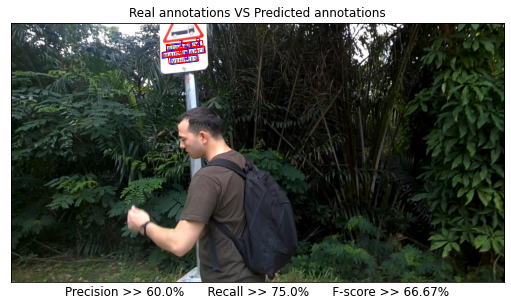



The average results are:
	- "precision" -> 60.0%
	- "recall" -> 75.0%
	- "fscore" -> 66.67%


In [3]:
####################################################################################################################################################
## LIBRARIES:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.backends.backend_pdf import PdfPages
import TextDetection_Functions as TDF
####################################################################################################################################################
## DISPLAY FUNCTIONS:

# Displayed Function 1: Represents the image along with its annotations and predictions, as well as metrics
def image_visualization(im, anns, pred_anns, metrics, save_flag):
    
    # The size of the figure is calculated to maintain the "aspect ratio":
    fig_size = (8.3, 8.3*(im.shape[0]/im.shape[1]))
    
    # NOTE : An A4 is [210mm X 297mm] or [8.3in X 11.7in] (Width X Height). To maintain the "aspect ratio"
    # You must adjust the height to the dimensions of the images to be represented.
    
    # The figure and the representation axis are created, the image is represented:
    fig, ax = plt.subplots(figsize=fig_size)
    ax.imshow(im.astype(np.uint8))
    
    # The list of true annotations is extracted, the polygon is created and added to the axis:
    for idx, BB in enumerate(anns):
        polygon = Polygon(BB, linewidth=1, edgecolor="b", facecolor="none")
        ax.add_patch(polygon)
        ax.text(np.sum(BB[:, 0])/4, np.sum(BB[:, 1])/4, str(idx + 1), fontsize=8, color="b")
        
    # The list of predicted annotations is extracted, the polygon is created and added to the axis:
    for idx, BBpred in enumerate(pred_anns):
        polygon = Polygon(BBpred, linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(polygon)
        ax.text(np.sum(BBpred[:, 0])/4, np.sum(BBpred[:, 1])/4, str(idx + 1), fontsize=8, color="r")
    
    # The axes are configured:
    ax.set_title("Real annotations VS Predicted annotations", fontsize=12)
    ax.set_xlabel("Precision >> {}%      Recall >> {}%      F-score >> {}%".format(metrics[0], metrics[1], metrics[2]), fontsize=12)
    ax.set_xlim(0, im.shape[1])
    ax.set_ylim(im.shape[0], 0)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
        
    # The image is saved as a high resolution PDF:
    if save_flag:
        pdf_pages = PdfPages("RESULT_annotations_and_metrics.pdf") #PDF Creation
        pdf_pages.savefig(fig, bbox_inches="tight", dpi=600)
        pdf_pages.close() #PDF closes
    return plt.gcf()
####################################################################################################################################################
## MAIN: Display of "recall", "precision" and "fscore" metrics

# Obtaining the working directory, generating the validation path and the weight path:
work_path = os.getcwd()
im_path = os.path.join(work_path, "Scene_Text_Datasets", "Validation_Images")
ann_path = os.path.join(work_path, "Scene_Text_Datasets", "Validation_Annotations")
weight_path = os.path.join(work_path, "Model_Ckeckpoints", "TFM_EAST_weights_ep200.h5")

# The model is generated and the weights are added:
print("The model and the images paths are loaded:")
EAST_model = TDF.model_assembler()
EAST_model.load_weights(weight_path)

# All the absolute paths of the images and annotations are loaded:
all_pair_path = TDF.load_images_path(im_path, ann_path)

# The vectors that store the metrics are initialized:
recall = np.array([])
precision = np.array([])
fscore = np.array([])

# Each of the pairs is traversed and predicted:
print("\nThe metrics of the validation images are extracted:")
for pair_path in all_pair_path:
    
    # The image and annotations adjusted to the EAST are loaded and the following is predicted:
    img, ann_true = TDF.load_inference_image(pair_path)
    pred_maps = EAST_model.predict(tf.convert_to_tensor(img[np.newaxis, :, :, :]), batch_size=1)
    
    # A division of the predicted maps is made and the "Bounding Boxes" are regenerated:
    geo_maps, score_map = tf.split(pred_maps, [5, 1], -1)
    boxes = TDF.box_regeneration(np.array(score_map[0, :, :, 0]), np.array(geo_maps[0]), (1, 1)) #Ratio (width, height)
    
    # Metrics are calculated per image and stored:
    metrics_dict = TDF.metrics(boxes, ann_true)
    recall = np.append(recall, metrics_dict["recall"])
    precision = np.append(precision, metrics_dict["precision"])
    fscore = np.append(fscore, metrics_dict["fscore"])
    
    # It is reported and displayed:
    metrics_values = (round(metrics_dict["precision"], ndigits=2), round(metrics_dict["recall"], ndigits=2), round(metrics_dict["fscore"], ndigits=2))
    print("\t- The image \"{}\" has obtained a \"precision\" of {}%, a \"recall\" of {}% and an \"fscore\" of {}%.".format(os.path.basename(pair_path[0]), metrics_values[0], metrics_values[1], metrics_values[2]))
    fig1 = image_visualization(img, ann_true, boxes, metrics_values, False)
    plt.show()
    print()

# Se saca los resultados medios de las metricas:
metrics_values = (round(np.sum(precision)/len(precision), ndigits=2), round(np.sum(recall)/len(recall), ndigits=2), round(np.sum(fscore)/len(fscore), ndigits=2))
print("\nThe average results are:\n\t- \"precision\" -> {}%\n\t- \"recall\" -> {}%\n\t- \"fscore\" -> {}%".format(metrics_values[0], metrics_values[1], metrics_values[2]))

Se presentan los datos de entrenamiento:
	- Training: A minimum "Loss" value of 1.906261086463928 has been detected at epoch 189.
	- Validation: A minimum "Loss" value of 3.513730049133301 has been detected at epoch 188.



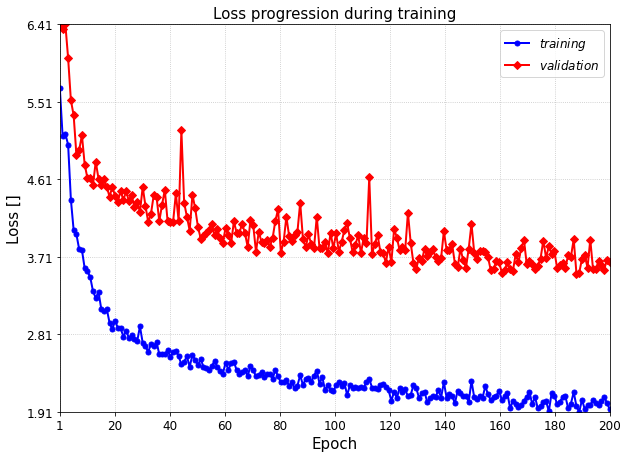


Se presentan los datos de las métricas:

The creator of EASTLite obtained the metrics at the time 400:
            	- "precision" -> 84.14%
            	- "recall" -> 67.45%
            	- "fscore" -> 74.88%

The actual EASTLite results are:
            	- "precision" -> 75.63% at epoch 175
            	- "recall" -> 37.34% at epoch 200
            	- "fscore" -> 46.7% at epoch 200



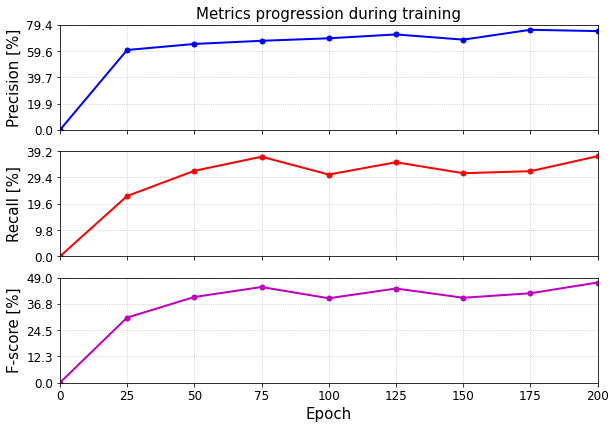

In [4]:
####################################################################################################################################################
## LIBRARIES:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.backends.backend_pdf import PdfPages
####################################################################################################################################################
## DISPLAY FUNCTIONS:

# Displayed Function 1: Represents training metrics
def training_visualization(csv_file, save_flag):
    
    # The CSV data is loaded:
    hist_data = pd.read_csv(csv_file, sep=chr(9))

    # Training history data is extracted and characteristic values are reported:
    epochs = np.arange(1,  hist_data.shape[0] + 1)
    train_loss =  np.array(hist_data[["loss", "loss_function"]].max(axis=1))
    val_loss =  np.array(hist_data[["val_loss", "val_loss_function"]].max(axis=1))
    print("\t- Training: A minimum \"Loss\" value of {} has been detected at epoch {}.".format(np.amin(train_loss), np.argmin(train_loss)+1))
    print("\t- Validation: A minimum \"Loss\" value of {} has been detected at epoch {}.\n".format(np.amin(val_loss), np.argmin(val_loss)+1 ))

    # Identify the altered maximum/minimum data for the "xticks"/"yticks" of the axis:
    ep_max = np.max(epochs)
    ep_min = np.min(epochs)
    loss_max = np.max(np.maximum(train_loss, val_loss))
    loss_min = np.min(np.minimum(train_loss, val_loss))
    
    # Create the figure and subplot representing the history data:
    fig, ax = plt.subplots(figsize=(8.3, 11.7/2))
    
    # NOTE : An A4 is [210mm X 297mm] or [8.3in X 11.7in] (Width X Height). If I want the figure to occupy half
    # page the height must be limited.

    # The "loss" data is represented:
    ax.plot(epochs, train_loss, 'bo-', linewidth=2, markersize=5, label="$training$")
    ax.plot(epochs, val_loss, 'rD-', linewidth=2, markersize=5, label="$validation$")
    ax.grid(True, which="both", linestyle=":", alpha=0.8)
    ax.set_xlim(ep_min, ep_max)
    ax.set_ylim(loss_min, loss_max)

    # Adjust the representation values of the X-Y axis of the axis:
    ax.set_xticks(np.linspace(ep_min, ep_max, num=11))
    ax.set_xticklabels(ax.get_xticks().astype(np.int64), fontsize=12)
    ax.set_yticks(np.linspace(loss_min, loss_max, num=6))
    ax.set_yticklabels(np.round(ax.get_yticks(), decimals=2), fontsize=12)

    # The axes of the "subplots" are configured:
    ax.set_position([0.06,0.1,0.92,0.92])
    for lb in ["top", "right", "bottom", "left"]:
        ax.spines[lb].set_visible(True)
    ax.set_title("Loss progression during training", fontsize=15)
    ax.set_ylabel("Loss []", fontsize=15)
    ax.set_xlabel("Epoch", fontsize=15)
    ax.legend(loc="upper right", fontsize=12)

    # The image is saved as a high resolution PDF:
    if save_flag:
        pdf_pages = PdfPages("GRAPH_EAST_Loos.pdf") #PDF Creation
        pdf_pages.savefig(fig, bbox_inches="tight", dpi=600)
        pdf_pages.close() #PDF closes
    return plt.gcf()

# Displayed Function 2: Represents the model evaluation metrics
def metrics_visualization(csv_file, save_flag):
    
    # The CSV data is loaded:
    all_data = pd.read_csv(csv_file, sep=chr(9))
    
    # The result of the EATLite creator is returned:
    print("""\nThe creator of EASTLite obtained the metrics at the time {}:
            \t- \"precision\" -> {}%
            \t- \"recall\" -> {}%
            \t- \"fscore\" -> {}%""".format(400, 84.14, 67.45, 74.88))
    
    # The real data obtained is output:
    epochs = np.array(all_data["epoch"]).astype(np.int64)
    precision = np.array(all_data["precision"])
    recall = np.array(all_data["recall"])
    fscore = np.array(all_data["fscore"])
    print("""\nThe actual EASTLite results are:
            \t- \"precision\" -> {}% at epoch {}
            \t- \"recall\" -> {}% at epoch {}
            \t- \"fscore\" -> {}% at epoch {}\n""".format(np.amax(precision), epochs[np.argmax(precision)], np.amax(recall), epochs[np.argmax(recall)], np.amax(fscore), epochs[np.argmax(fscore)]))
    
    # Identify the altered maximum/minimum data for the "xticks"/"yticks" of each axis:
    ep_max = np.max(epochs)
    ep_min = np.min(epochs)
    precision_max = np.max(1.05*precision) #Slight increase to make it look better
    precision_min = np.min(precision)
    recall_max = np.max(1.05*recall) #Slight increase to make it look better
    recall_min = np.min(recall)
    fscore_max = np.max(1.05*fscore) #Slight increase to make it look better
    fscore_min = np.min(fscore)
    
    # Create the figure and the data representation subplots:
    fig, axs = plt.subplots(1, 3, figsize=(8.3, 11.7/2))
    
    # NOTE : An A4 is [210mm X 297mm] or [8.3in X 11.7in] (Width X Height). If I want the figure to occupy half
    # page height should be limited
    
    # The "precision" data is represented:
    axs[0].plot(epochs, precision, 'bo-', linewidth=2, markersize=5)
    axs[0].grid(True, which="both", linestyle=":", alpha=0.8)
    axs[0].set_xlim(ep_min, ep_max)
    axs[0].set_ylim(precision_min, precision_max)
    
    # The "recall" data is represented:
    axs[1].plot(epochs, recall, 'ro-', linewidth=2, markersize=5)
    axs[1].grid(True, which="both", linestyle=":", alpha=0.8)
    axs[1].set_xlim(ep_min, ep_max)
    axs[1].set_ylim(recall_min, recall_max)
    
    # The "fscore" data is represented:
    axs[2].plot(epochs, fscore, 'mo-', linewidth=2, markersize=5)
    axs[2].grid(True, which="both", linestyle=":", alpha=0.8)
    axs[2].set_xlim(ep_min, ep_max)
    axs[2].set_ylim(fscore_min, fscore_max)
    
    # Adjust the representation values of the X-Y-Y axes of each "subplots":
    axs[0].set_xticks(epochs)
    axs[0].set_xticklabels([], fontsize=12)
    axs[0].set_yticks(np.linspace(precision_min, precision_max, num=5))
    axs[0].set_yticklabels(np.round(axs[0].get_yticks(), decimals=1), fontsize=12)
    axs[1].set_xticks(epochs)
    axs[1].set_xticklabels([], fontsize=12)
    axs[1].set_yticks(np.linspace(recall_min, recall_max, num=5))
    axs[1].set_yticklabels(np.round(axs[1].get_yticks(), decimals=1), fontsize=12)
    axs[2].set_xticks(epochs)
    axs[2].set_xticklabels(axs[2].get_xticks(), fontsize=12)
    axs[2].set_yticks(np.linspace(fscore_min, fscore_max, num=5))
    axs[2].set_yticklabels(np.round(axs[2].get_yticks(), decimals=1), fontsize=12)

    # The axes of the "subplots" are configured:
    axs[0].set_position([0.08,0.7,0.9,0.25])
    axs[1].set_position([0.08,0.4,0.9,0.25])
    axs[2].set_position([0.08,0.1,0.9,0.25])
    for lb in ["top", "right", "bottom", "left"]:
        axs[0].spines[lb].set_visible(True)
        axs[1].spines[lb].set_visible(True)
        axs[2].spines[lb].set_visible(True)
    axs[0].set_title("Metrics progression during training", fontsize=15)
    axs[0].set_ylabel("Precision [%]", fontsize=15)
    axs[1].set_ylabel("Recall [%]", fontsize=15)
    axs[2].set_ylabel("F-score [%]", fontsize=15)
    axs[2].set_xlabel("Epoch", fontsize=15)

    # The image is saved as a high resolution PDF:
    if save_flag:
        pdf_pages = PdfPages("GRAPH_EAST_Metrics.pdf") #PDF Creation
        pdf_pages.savefig(fig, bbox_inches="tight", dpi=600)
        pdf_pages.close() #Close the PDF
    return plt.gcf()

####################################################################################################################################################
## MAIN: Viewing training graphs and metrics

# Obtaining the working directory, generating the validation path and the weight path:
work_path = os.getcwd()
data_path = os.path.join(work_path, "Model_Ckeckpoints")

# Training data is represented:
print("Se presentan los datos de entrenamiento:")
train_fig = training_visualization(os.path.join(data_path, "Performance_Data.csv"), True)
plt.show()

# Training data is represented:
print("\nSe presentan los datos de las métricas:")
met_fig = metrics_visualization(os.path.join(data_path, "Metrics_Data.csv"), True)
plt.show()